In [1]:
# import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.stats as sts
import seaborn as sns
import statsmodels.api as sm

In [2]:
#load raw data
life_filepath = os.path.join('DataSets', 'life_expectancy_at_birth.csv')
pop_filepath = os.path.join('DataSets', 'population_by_education_level.csv')
eu_filepath = os.path.join('DataSets', 'EU_Country_Codes.csv')

raw_life_df = pd.read_csv(life_filepath)
life_df = raw_life_df.dropna()

raw_pop_df = pd.read_csv(pop_filepath)
pop_df = raw_pop_df.dropna()

eu_df = pd.read_csv(eu_filepath,names=['geography','country'], header = None).drop_duplicates()

In [4]:
# merge data frames
life_pop_df = pd.merge(pop_df, life_df, on=['date','geography','sex'], how='inner')
raw_life_pop_eu_df = pd.merge(life_pop_df, eu_df, on='geography', how='left')

In [5]:
raw_life_pop_eu_df.head()

,unit_x,sex,age,isced11,geography,date,value_x,unit_y,statinfo,value_y,country
0,THS,F,Y15-19,ED0-2,AT,2019,149.6,YR,LE_0,84.2,Austria
1,THS,F,Y15-19,ED3_4,AT,2019,52.4,YR,LE_0,84.2,Austria
2,THS,F,Y15-19,ED5-8,AT,2019,6.9,YR,LE_0,84.2,Austria
3,THS,F,Y15-19,TOTAL,AT,2019,208.8,YR,LE_0,84.2,Austria
4,THS,F,Y15-24,ED0-2,AT,2019,173.8,YR,LE_0,84.2,Austria


In [6]:
raw_life_pop_eu_df.shape

(96908, 11)

In [7]:
life_pop_eu_df = raw_life_pop_eu_df[raw_life_pop_eu_df['isced11']!='TOTAL']
life_pop_eu_df.shape

(74230, 11)

In [8]:
# drop columns
life_pop_eu_df = life_pop_eu_df.drop(columns=['unit_x', 'unit_y','statinfo' ])

In [9]:
# rename columns
life_pop_eu_df = life_pop_eu_df.rename(columns={'value_y': 'age_in_year',
                                               'value_x':'population_in_THS',})
life_pop_eu_df['age'].unique()

array(['Y15-19', 'Y15-24', 'Y15-39', 'Y15-59', 'Y15-64', 'Y15-74',
       'Y20-24', 'Y20-64', 'Y25-29', 'Y25-39', 'Y25-49', 'Y25-54',
       'Y25-59', 'Y25-64', 'Y25-74', 'Y30-34', 'Y35-39', 'Y40-44',
       'Y40-59', 'Y40-64', 'Y45-49', 'Y50-54', 'Y50-59', 'Y50-64',
       'Y50-74', 'Y55-59', 'Y55-64', 'Y60-64', 'Y65-69'], dtype=object)

In [10]:
life_pop_eu_df['date'].unique()

array([2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009,
       2008])

In [11]:
# calculate the total population for each country, each age group, each year and each sex
total_pop_groupby = pd.DataFrame(life_pop_eu_df.groupby(['sex','age', 'geography','date']).sum()['population_in_THS'])
total_pop_groupby = total_pop_groupby.rename(columns={'population_in_THS': 'population_total'})

In [12]:
# merge the total population to dataframe
life_pop_eu_total_df = pd.merge(life_pop_eu_df, total_pop_groupby, on=['sex', 'age','geography','date'],how='inner')

In [13]:
# add a column with percentage calculated
life_pop_eu_total_df['percentage'] = life_pop_eu_total_df['population_in_THS']/life_pop_eu_total_df['population_total']

In [14]:
# get a dataframe and ready for analysis
clean_df = life_pop_eu_total_df

In [15]:
# EDA of life expentancy
life_df_ana = life_df.reset_index()
life_df_ana.head()

,index,unit,sex,statinfo,geography,date,value
0,0,YR,F,LE_0,AT,2008,83.3
1,1,YR,F,LE_0,BE,2008,82.6
2,2,YR,F,LE_0,BG,2008,77.0
3,3,YR,F,LE_0,CH,2008,84.6
4,4,YR,F,LE_0,CY,2008,82.9


In [16]:
#statistic description of life expectancy
country_lf = life_df_ana.groupby(['sex', 'geography'])['value']
country_lf_stat = country_lf.agg(['mean', 'median','var','std','sem']).sort_values(by=['var'])
country_lf_stat

mean  median       var       std       sem
sex geography                                                 
F   DE         83.191667   83.10  0.097197  0.311764  0.089999
    NL         83.175000   83.20  0.098409  0.313702  0.090558
    AT         83.775000   83.80  0.105682  0.325087  0.093845
    FR         85.550000   85.65  0.137273  0.370503  0.106955
    IS         84.100000   84.10  0.158182  0.397721  0.114812
...                  ...     ...       ...       ...       ...
M   SK         72.833333   73.00  1.155152  1.074780  0.310262
    MT         79.433333   79.70  1.416970  1.190365  0.343629
    LV         69.008333   69.20  1.506288  1.227309  0.354294
    LT         68.891667   68.85  2.731742  1.652798  0.477122
    EE         72.216667   72.60  2.945152  1.716144  0.495408

[66 rows x 5 columns]

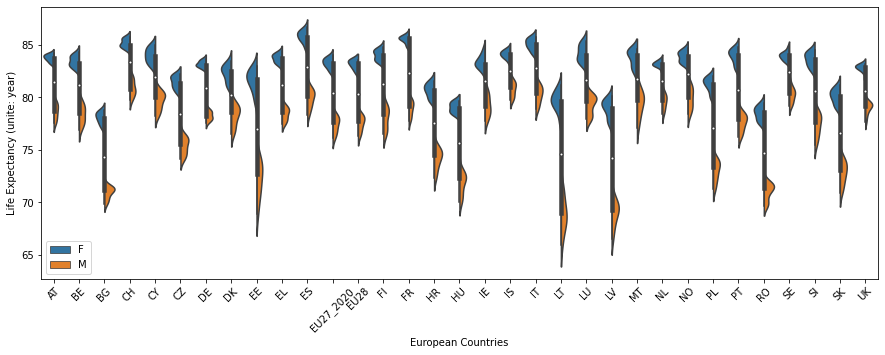

In [17]:
# violin plot of the life expectancy of Female and male from 2008-2019
plt.figure(figsize=(15,5))
chart = sns.violinplot(x='geography', y='value', data = life_df_ana, width=0.8, hue='sex', split=True)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart.legend(loc=3)
plt.ylabel('Life Expectancy (unite: year)')
plt.xlabel('European Countries')
plt.savefig('violinBycountry2.png')

In [18]:
# calulate the mean, median, var, std, and sem of all europe countries for each gender  
yearly_lf = life_df_ana.groupby(['sex', 'date'])['value']
yearly_lf_stat = yearly_lf.agg(['mean', 'median','var','std','sem']).sort_values(by=['mean']).reset_index()
yearly_lf_stat

,sex,date,mean,median,var,std,sem
0,M,2008,75.333333,76.90,15.719792,3.964819,0.690186
1,M,2009,75.669697,77.40,14.217803,3.770650,0.656386
2,M,2010,75.937500,77.35,13.990161,3.740342,0.661205
3,M,2011,76.406061,77.90,13.179337,3.630336,0.631960
4,M,2012,76.456250,77.90,13.070282,3.615285,0.639098
5,M,2013,76.903125,78.20,12.729990,3.567911,0.630724
6,M,2015,77.209091,78.70,12.373977,3.517666,0.612347
7,M,2014,77.257576,78.70,13.111894,3.621035,0.630341
8,M,2016,77.509091,78.90,12.428977,3.525475,0.613707
9,M,2017,77.624242,78.90,12.054394,3.471944,0.604388


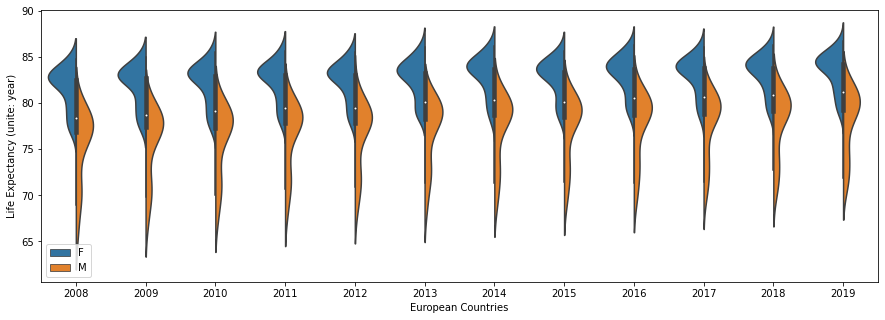

In [19]:
# plot the life expentacy vs time
plt.figure(figsize=(15,5))
chart = sns.violinplot(x='date', y='value', data = life_df_ana, width=0.8, hue='sex', split=True)
chart.set_xticklabels(chart.get_xticklabels())
chart.legend(loc=3)
plt.ylabel('Life Expectancy (unite: year)')
plt.xlabel('European Countries')
plt.savefig('violinByyear2.png')

In [20]:
# yw = os.path.join('DataSets', 'complete_dataset.csv')
# r_merge_df = pd.read_csv(yw)
# r_merge_df.head()

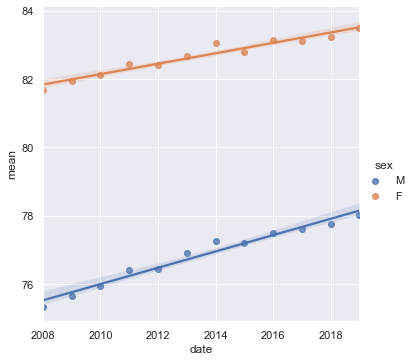

In [21]:
# linear regression of average life expentacy of europe countries vi time
sns.set_theme(color_codes=True)
lf_reg_gender = sns.lmplot(x='date', y='mean', hue='sex', data=yearly_lf_stat)
plt.savefig('regByyear.png')

In [22]:
# fit linear model regard to the average life expentacy of europe countries vi time
model = sm.OLS.from_formula('mean~sex*date', data=yearly_lf_stat)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     3162.
Date:                Tue, 03 Aug 2021   Prob (F-statistic):           6.27e-27
Time:                        09:50:41   Log-Likelihood:                 13.519
No. Observations:                  24   AIC:                            -19.04
Df Residuals:                      20   BIC:                            -14.33
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -224.1535     25.410     -8.822      0.000    -277.157    -171.150
sex[T.M]       -179.5432     35.935     -4.996      0.000    -254.501    -104.585
date              0.1524      0.013     12.076      0.000       0.126       0.179
sex[T.M]:date     0.0863      0.018      4.834      0.000       0.049       0.123
==============================================================================
Omnibus:                        3.061   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.216   Jarque-Bera (JB):                2.473
Skew:                           0.771   Prob(JB):                        0.290
Kurtosis:                       2.690   Cond. No.                     3.07e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.07e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
# write a function to do chisquare test of female and male at the same education level, the same country, and the same age group
def chi2test(edu_level, geography_ID, age_level):
    fm_pop = clean_df[(clean_df['sex']=='F') & (clean_df['isced11']==edu_level) & (clean_df['geography']==geography_ID) & (clean_df['age']==age_level)]
    m_pop = clean_df[(clean_df['sex']=='M') & (clean_df['isced11']==edu_level) & (clean_df['geography']==geography_ID) & (clean_df['age']==age_level)]
    fm_m_pop = pd.merge(fm_pop, m_pop, on='date', how='inner')
    chi2_stats, chi2pvalue = sts.chisquare(fm_m_pop['population_in_THS_x'].tolist(), fm_m_pop['population_in_THS_y'].tolist())
    return chi2_stats, chi2pvalue

In [24]:
# iterate to do the chisqure test
xlist = []
ylist = []
edu = []
eu_ID = []
age_level = []
for i in clean_df['isced11'].unique():
    for j in clean_df['geography'].unique():
        for k in clean_df['age'].unique():
            x, y = chi2test(i,j,k)
            xlist.append(x)
            ylist.append(y)
            edu.append(i)
            eu_ID.append(j)
            age_level.append(k)

In [25]:
# create a dataframe to store the results of chisquare test
chi2_df = pd.DataFrame({'isced11': edu,
                        'geography': eu_ID,
                        'age': age_level,
                       'chi2_stats': xlist,
                       'chi2_pvalue': ylist})  
# get the rows that female and male have significant difference at 95% confident level
diff = chi2_df[(chi2_df['chi2_pvalue']<0.05)]
diff.head()

,isced11,geography,age,chi2_stats,chi2_pvalue
0,ED0-2,AT,Y15-19,23.545504,1.479151e-02
1,ED0-2,AT,Y15-24,35.692368,1.903627e-04
3,ED0-2,AT,Y15-59,489.294151,6.147911e-98
4,ED0-2,AT,Y15-64,792.547784,7.542331e-163
5,ED0-2,AT,Y15-74,1711.129900,0.000000e+00


In [26]:
# find out the countries that male and female have significant difference in all education levels
bar_df = diff.groupby(['geography', 'age']).count()['isced11'].reset_index()

geographyies = bar_df[bar_df['isced11']==4]['geography'].unique().tolist()
for geography in geographyies:
    print(eu_df[eu_df['geography']==geography])

  geography  country
5        DE  Germany
  geography  country
4        DK  Denmark
Empty DataFrame
Columns: [geography, country]
Index: []
Empty DataFrame
Columns: [geography, country]
Index: []
   geography  country
11        HR  Croatia
   geography         country
28        UK  United Kingdom


In [34]:
# get the rows that female and male have no significant difference at 95% confident level
no_diff = chi2_df[(chi2_df['chi2_pvalue']>0.05)]
no_diff.head()

,isced11,geography,age,chi2_stats,chi2_pvalue
2,ED0-2,AT,Y15-39,17.074625,0.105687
6,ED0-2,AT,Y20-24,19.377896,0.054638
8,ED0-2,AT,Y25-29,5.070201,0.927719
34,ED0-2,BE,Y15-74,10.958370,0.446757
43,ED0-2,BE,Y25-74,14.046200,0.230448


In [28]:
# find out the countries that male and female have significant difference in all education levels
bar_df2 = no_diff.groupby(['geography', 'age']).count()['isced11'].reset_index()

geographyies = bar_df2[bar_df2['isced11']==4]['geography'].unique().tolist()
for geography in geographyies:
    item = eu_df[eu_df['geography']==geography]
    print(item)

  geography  country
7        IE  Ireland
   geography     country
16        LU  Luxembourg


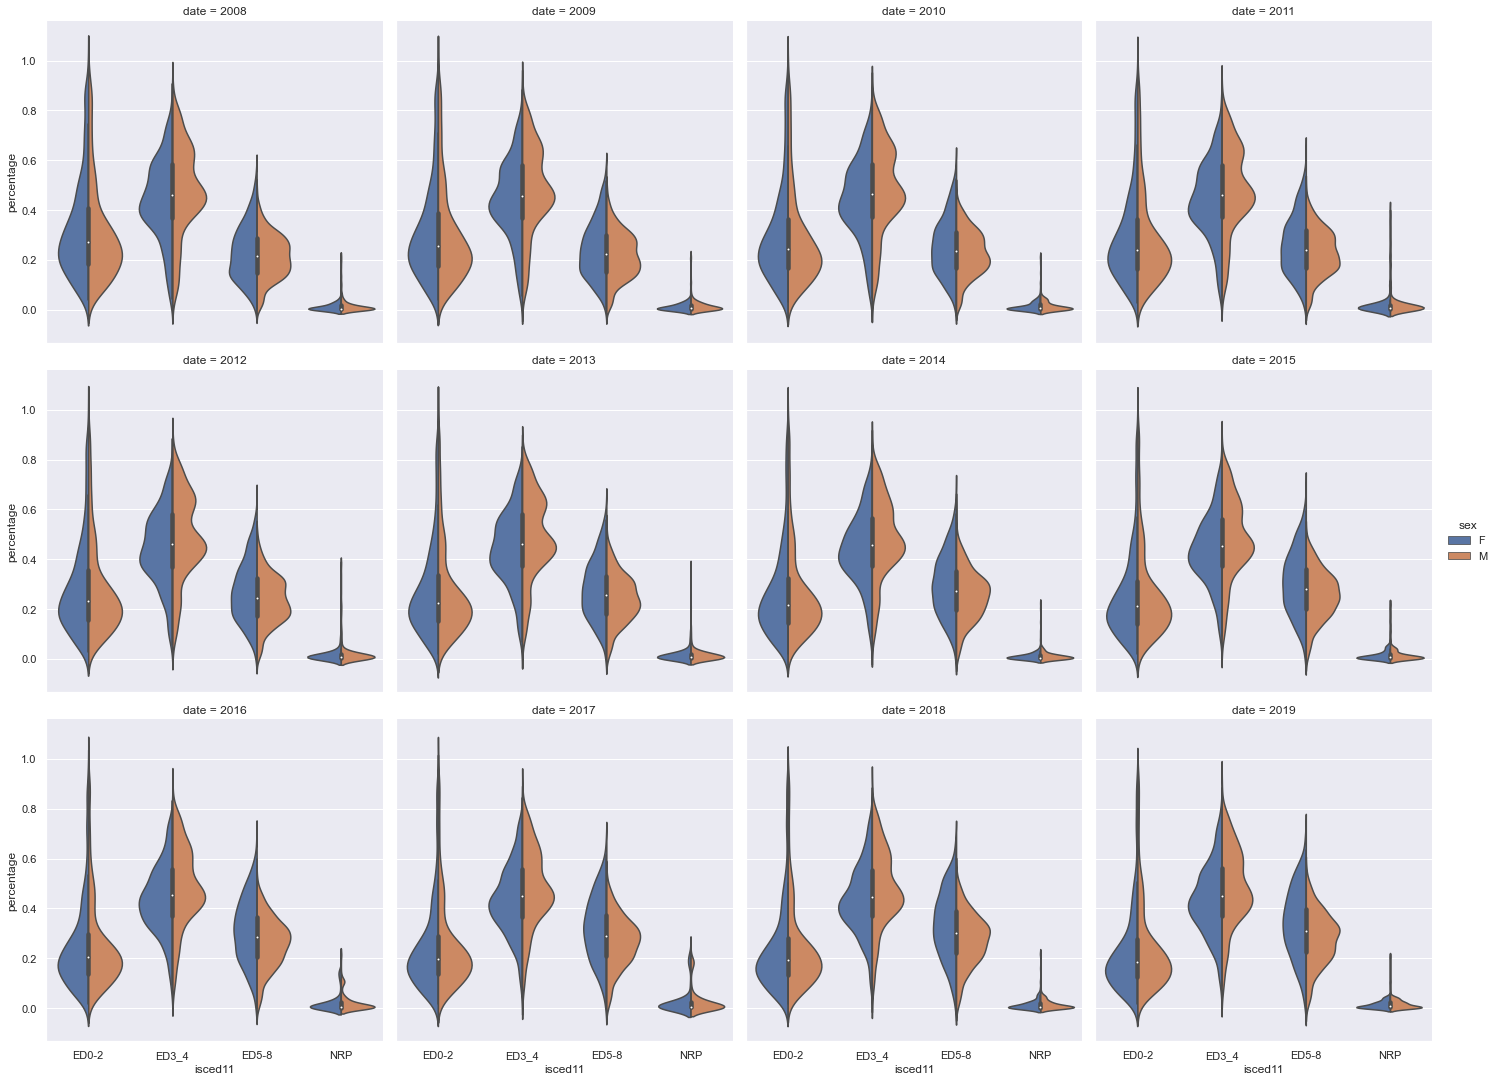

In [29]:
# violin plots show the distributions of percentage of population for education levels across the europe countries 
# along all age groups
sns.catplot(x='isced11', y='percentage',col='date', hue='sex', split=True, col_wrap=4, data=clean_df, kind='violin')
plt.savefig('education_whole_europe.png')

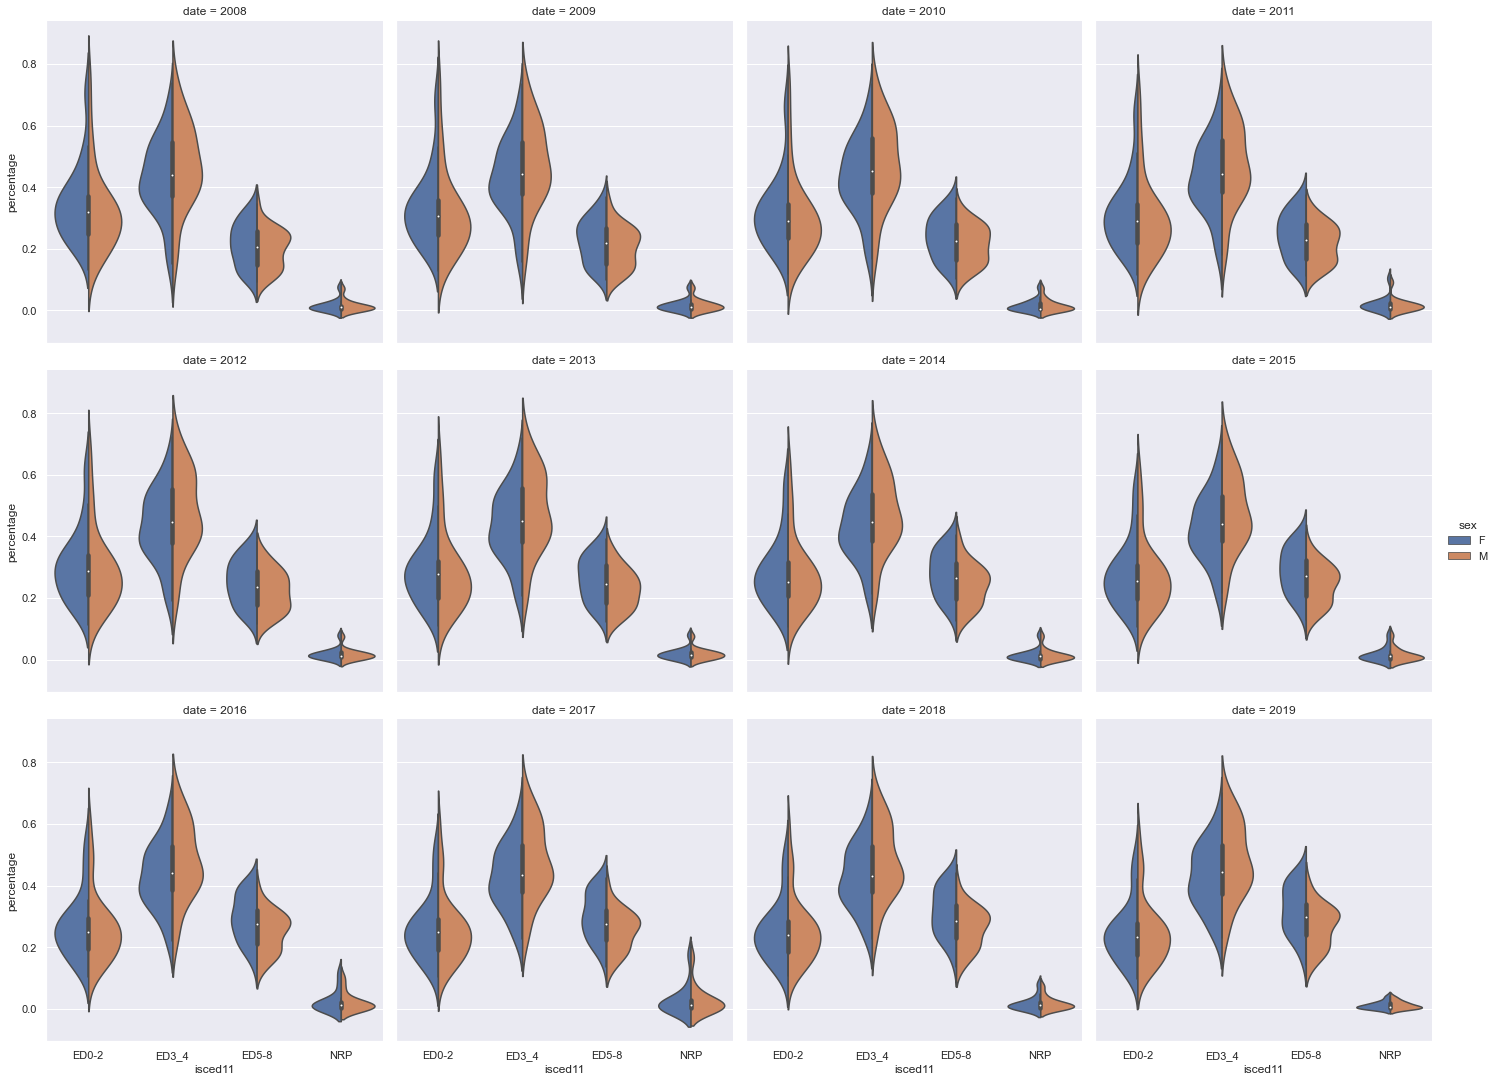

In [30]:
# violin plots show the distributions of percentage of population for education levels at age group Y15-74 across the europe countries

sns.catplot(x='isced11', y='percentage',col='date', hue='sex', split=True, col_wrap=4, 
            data=clean_df[clean_df['age']=='Y15-74'], kind='violin')
plt.savefig('education_whole_europe_Y15_74.png')

In [38]:
# sample country 
geography_diff = 'UK'
geography_no_diff = 'LU'
age = 'Y15-74'

EX_UK_df = clean_df[(clean_df['geography']==geography_diff) & 
                (clean_df['age']==age)]
ave_EX_UK_df = EX_UK_df.groupby(['sex','isced11']).mean()['percentage'].reset_index()

EX_LU_df = clean_df[(clean_df['geography']==geography_no_diff) & 
                (clean_df['age']==age)]
ave_EX_LU_df = EX_LU_df.groupby(['sex','isced11']).mean()['percentage'].reset_index()

,sex,isced11,percentage
0,F,ED0-2,0.306223
1,F,ED3_4,0.350360
2,F,ED5-8,0.298255
3,F,NRP,0.049268
4,M,ED0-2,0.265879
5,M,ED3_4,0.362975
6,M,ED5-8,0.328136
7,M,NRP,0.046920


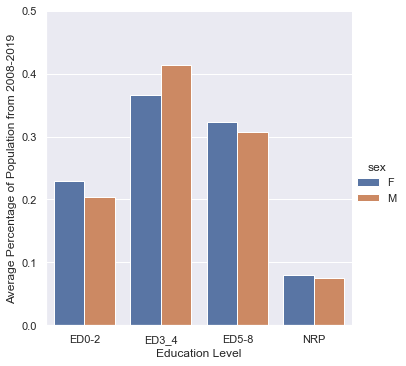

In [71]:
# sample country UK
ax_UK = sns.catplot(x='isced11', y='percentage', hue='sex', data=ave_EX_UK_df, kind='bar', ci=None)
ax_UK.set(ylim=(0, 0.5))
ax_UK.set(xlabel='Education Level', ylabel='Average Percentage of Population from 2008-2019')
plt.savefig('education_UK.png')

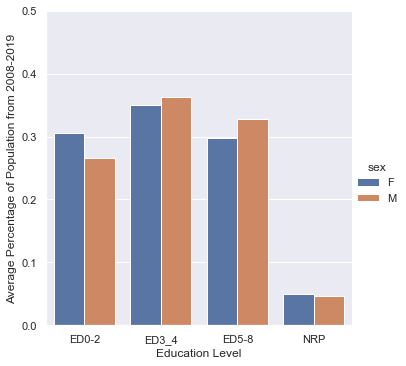

In [73]:
# sample country LU
ax_LU = sns.catplot(x='isced11', y='percentage', hue='sex', data=ave_EX_LU_df, kind='bar', ci=None)
ax_LU.set(ylim=(0, 0.5))
ax_LU.set(xlabel='Education Level', ylabel='Average Percentage of Population from 2008-2019')
plt.savefig('education_LU.png')

In [46]:
yearly_pop_edu = clean_df.groupby(['sex', 'age', 'isced11','date'])['percentage']
yearly_pop_edu_stat = yearly_pop_edu.agg(['mean', 'median','var','std','sem']).reset_index()

In [47]:
# pop_groupby_age_edu = yearly_pop_edu_stat[(yearly_pop_edu_stat['age']=='Y15-19') & 
#                                           (yearly_pop_edu_stat['isced11']=='ED3_4')].reset_index()
pop_groupby_age_edu02 = yearly_pop_edu_stat[ yearly_pop_edu_stat['isced11']=='ED0-2'].reset_index()

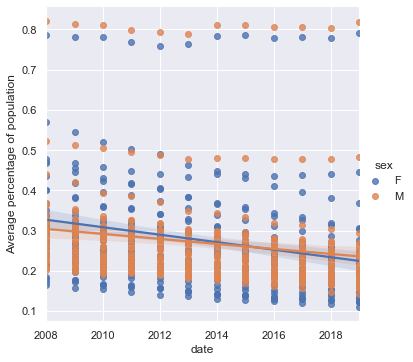

In [57]:
sns.set_theme(color_codes=True)
lf_reg_gender = sns.lmplot(x='date', y='mean', hue='sex', data=pop_groupby_age_edu02)
lf_reg_gender.set(ylabel='Average percentage of population')
plt.savefig('education02_trend.png')

In [49]:
pop_groupby_age_edu34 = yearly_pop_edu_stat[ yearly_pop_edu_stat['isced11']=='ED3_4'].reset_index()

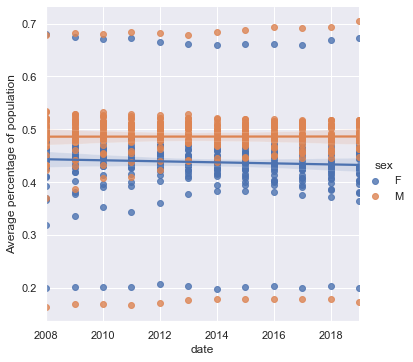

In [58]:
sns.set_theme(color_codes=True)
lf_reg_gender = sns.lmplot(x='date', y='mean', hue='sex', data=pop_groupby_age_edu34)
lf_reg_gender.set(ylabel='Average percentage of population')
plt.savefig('education34_trend.png')

In [51]:
pop_groupby_age_edu58 = yearly_pop_edu_stat[ yearly_pop_edu_stat['isced11']=='ED5-8'].reset_index()

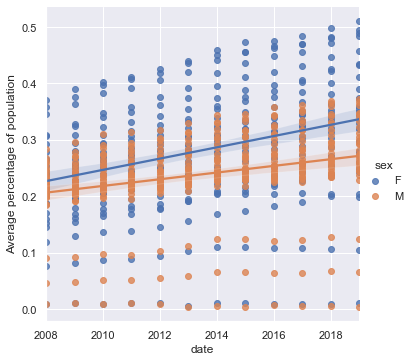

In [59]:
sns.set_theme(color_codes=True)
lf_reg_gender = sns.lmplot(x='date', y='mean', hue='sex', data=pop_groupby_age_edu58)
lf_reg_gender.set(ylabel='Average percentage of population')
plt.savefig('education58_trend.png')

In [53]:
pop_groupby_age_edu = yearly_pop_edu_stat[ yearly_pop_edu_stat['isced11']=='ED5-8'].reset_index()
pop_groupby_age_edu

,index,sex,age,isced11,date,mean,median,var,std,sem
0,24,F,Y15-19,ED5-8,2008,0.009066,0.007157,0.000041,0.006370,0.002601
1,25,F,Y15-19,ED5-8,2009,0.010749,0.007255,0.000092,0.009582,0.003912
2,26,F,Y15-19,ED5-8,2010,0.009763,0.006924,0.000053,0.007309,0.002984
3,27,F,Y15-19,ED5-8,2011,0.009981,0.008772,0.000043,0.006584,0.002688
4,28,F,Y15-19,ED5-8,2012,0.010366,0.009049,0.000046,0.006806,0.002779
...,...,...,...,...,...,...,...,...,...,...
691,2767,M,Y65-69,ED5-8,2015,0.218626,0.216278,0.004926,0.070183,0.012217
692,2768,M,Y65-69,ED5-8,2016,0.225521,0.224872,0.005210,0.072178,0.012565
693,2769,M,Y65-69,ED5-8,2017,0.224635,0.230233,0.005099,0.071406,0.012430
694,2770,M,Y65-69,ED5-8,2018,0.233427,0.235274,0.005517,0.074275,0.012930


In [54]:
# create a new dataframe for plot
lf_edu_plot = pd.merge(pop_groupby_age_edu58,yearly_lf_stat, on=['sex','date'], how='left', suffixes=("_edu", "_life"))
lf_edu_plot

,index,sex,age,isced11,date,mean_edu,median_edu,var_edu,std_edu,sem_edu,mean_life,median_life,var_life,std_life,sem_life
0,24,F,Y15-19,ED5-8,2008,0.009066,0.007157,0.000041,0.006370,0.002601,81.681818,82.5,5.090909,2.256304,0.392772
1,25,F,Y15-19,ED5-8,2009,0.010749,0.007255,0.000092,0.009582,0.003912,81.936364,82.7,4.890511,2.211450,0.384964
2,26,F,Y15-19,ED5-8,2010,0.009763,0.006924,0.000053,0.007309,0.002984,82.134375,83.0,5.036522,2.244220,0.396726
3,27,F,Y15-19,ED5-8,2011,0.009981,0.008772,0.000043,0.006584,0.002688,82.445455,83.1,4.513807,2.124572,0.369841
4,28,F,Y15-19,ED5-8,2012,0.010366,0.009049,0.000046,0.006806,0.002779,82.406250,83.1,4.323185,2.079227,0.367559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,2767,M,Y65-69,ED5-8,2015,0.218626,0.216278,0.004926,0.070183,0.012217,77.209091,78.7,12.373977,3.517666,0.612347
692,2768,M,Y65-69,ED5-8,2016,0.225521,0.224872,0.005210,0.072178,0.012565,77.509091,78.9,12.428977,3.525475,0.613707
693,2769,M,Y65-69,ED5-8,2017,0.224635,0.230233,0.005099,0.071406,0.012430,77.624242,78.9,12.054394,3.471944,0.604388
694,2770,M,Y65-69,ED5-8,2018,0.233427,0.235274,0.005517,0.074275,0.012930,77.763636,79.1,12.201136,3.493013,0.608055


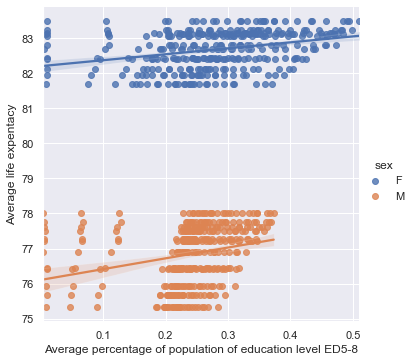

In [69]:
# plot the linear regression
sns.set_theme(color_codes=True)
lf_reg_gender = sns.lmplot(x='mean_edu', y='mean_life', hue='sex', data=lf_edu_plot)
lf_reg_gender.set(xlabel='Average percentage of population of education level ED5-8', 
                  ylabel='Average life expentacy')
plt.savefig('education58_life_regression.png')

In [70]:
# fit the linear regression model
model2 = sm.OLS.from_formula('mean_life~sex*mean_edu', data=lf_edu_plot)
result2 = model2.fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              mean_life   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     4341.
Date:                Tue, 03 Aug 2021   Prob (F-statistic):               0.00
Time:                        10:53:21   Log-Likelihood:                -713.70
No. Observations:                 696   AIC:                             1435.
Df Residuals:                     692   BIC:                             1454.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            82.2012      0.105    781.673      0.000      81.995      82.408
sex[T.M]             -6.0970      0.161    -37.774      0.000      -6.414      -5.780
mean_edu              1.6977      0.350      4.847      0.000       1.010       2.385
sex[T.M]:mean_edu     1.3806      0.602      2.295      0.022       0.199       2.562
==============================================================================
Omnibus:                       23.637   Durbin-Watson:                   0.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.336
Skew:                          -0.282   Prob(JB):                     0.000172
Kurtosis:                       2.471   Cond. No.                         30.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""